In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

from config import Cfg as cfg

import mysql.connector

%matplotlib inline

## Race results

In [171]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [172]:
len(df_results.athlete.unique())

643055

## Races info

In [173]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [174]:
# -----------
# -- RACES --
# -----------


# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# remove worldchampionship
df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
df_races = df_races.loc[df_races.race != 'worldchampionship']


# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races['race'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019
df_results = df_results.loc[df_results['year'] < 2019]

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"

### what do we have left to work with?

In [175]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1592599
  Number of athletes: 575481
-- Races dataset --
  Number of active races: 157


## Race count and unique race count per athlete

#### To prevent cold-start problem keep only people with at least 2 different races.

In [176]:
# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
min_count_diff_races = 2
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_count_diff_races) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of different individuals:", len(valid_athletes))
print("Number of single results:", len(df_results_filtered))

Number of different individuals: 248360
Number of single results: 1190216


,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,country,date,fulldata,score,swim_score,run_score,bike_score,gender,n_different_races,n_races
0,1518207,u0,M75-79,1,1073,1209,2440,678,11150,469,...,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,7,10
1,1518209,u1,M75-79,2,1141,1301,3539,679,13127,461,...,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,7,12
2,1518210,u2,M65-69,1,181,202,1895,377,9944,243,...,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,12,24
3,1518211,u3,M80-84,1,1281,1475,3135,784,13528,726,...,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,5,15
4,1518213,u4,M55-59,1,134,152,2150,350,9711,282,...,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,6,9


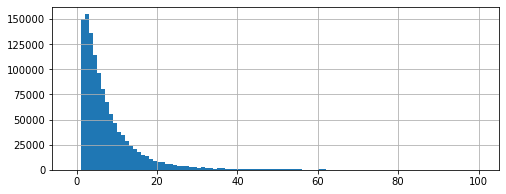

In [177]:
df_results_filtered['n_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(8, 3))
df_results_filtered.head(5)

A majority of athletes have < 20 races

# MODEL 1: the more you do a race, the more you implicitely like it

#### Count of each race for each entrants

In [178]:
results_data = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

results_data.head()

,athlete,race,count
0,u0,brazil,1
1,u0,california70.3,1
2,u0,cozumel,2
3,u0,honu70.3,1
4,u0,loscabos,2


#### How many times the race has been done

In [179]:
race_popularity = (results_data
    .groupby(by = ['race'])['count']
    .sum()
    .reset_index()
    .rename(columns = {'count': 'total_count'})
)
race_popularity.head()

,race,total_count
0,Arizona70.3,5485
1,DunLaoghaire70.3,896
2,Florianopolis70.3,916
3,Haugesund70.3,2153
4,IMsubicbay,1152


In [180]:
print(race_popularity['total_count'].describe())
# print(race_popularity['total_count'].quantile(np.arange(.5, 1, .01)))

count      153.000000
mean      7779.189542
std       7610.135006
min        313.000000
25%       2375.000000
50%       4784.000000
75%      11083.000000
max      38737.000000
Name: total_count, dtype: float64


#### Add demographics info for users (if we want to filter later)

In [181]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

user_data_with_race_count = results_data.merge(race_popularity, left_on = 'race', right_on = 'race', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count.head(10)

,athlete,race,count,total_count,gender,country
0,u0,brazil,1,12516,M,USA
1,u0,california70.3,1,29870,M,USA
2,u0,cozumel,2,16438,M,USA
3,u0,honu70.3,1,15449,M,USA
4,u0,loscabos,2,3532,M,USA
5,u0,mardelplata,1,1847,M,USA
6,u0,xiamen70.3,2,2185,M,USA
7,u1,cairns,1,7298,M,JPN
8,u1,canada70.3,1,2539,M,JPN
9,u1,honu70.3,3,15449,M,JPN


## --## -- Implemeting the Nearest Neighbor Model

#### Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an m x n array, where m is the number of artists and n is the number of users. To reshape the dataframe, we’ll pivot the dataframe to the wide format with artists as rows and users as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [182]:
from scipy.sparse import csr_matrix, save_npz

wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix.npz', wide_race_data_sparse)

#### Fitting the Model

Time to implement the model. We’ll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [183]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

#### Making Recommendations

And we’re finally ready to make some recommendations!

In [184]:
query_index = np.random.choice(wide_race_data.shape[0])
distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for luxembourg70.3:

1: Maastricht, with distance of 0.8463307204521767.
2: kraichgau70.3, with distance of 0.86239924603374.
3: vichy70.3, with distance of 0.8747842882051549.
4: france70.3, with distance of 0.8835074758269879.
5: germany, with distance of 0.885978112704221.
6: salzburg70.3, with distance of 0.9013549242911323.
7: switzerland70.3, with distance of 0.9054399606701558.
8: mallorca70.3, with distance of 0.9073549633527157.
9: challengeroth, with distance of 0.9146828699568916.


# MODEL 2: Binary racing. Either an entrants raced a race or not

Previously, we used the actual play counts as values in our artist vectors. Another approach would be convert each vector into a binary (1 or 0): either a user played the song or they did not. We can do this by applying the `sign` function in `numpy` to each column in the dataframe.

In [185]:
wide_race_data_zero_one = wide_race_data.apply(np.sign)
wide_race_data_zero_one_sparse = csr_matrix(wide_race_data_zero_one.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix_binary.npz', wide_race_data_zero_one_sparse)

In [186]:
model_knn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn_binary.fit(wide_race_data_zero_one_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

## Let’s make a quick comparison. Which recommendations look better?

In [187]:
distances, indices = model_knn_binary.kneighbors(wide_race_data_zero_one.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data_zero_one.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data_zero_one.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for luxembourg70.3:

1: kraichgau70.3, with distance of 0.8200678531640405.
2: Maastricht, with distance of 0.856314601686226.
3: germany, with distance of 0.863504262560558.
4: france70.3, with distance of 0.8666462916268989.
5: vichy70.3, with distance of 0.8675706711938609.
6: switzerland70.3, with distance of 0.8699505420804321.
7: salzburg70.3, with distance of 0.8828284015654798.
8: mallorca70.3, with distance of 0.8882372313465947.
9: challengeroth, with distance of 0.9005335958073152.


The binary data representation recommendations look qualitatively similar.

Again, it’s not obvious which method is better. Since ultimately it’s the users’s future actions that indicate which recommender system is better, it’s a perfect candidate for A/B Testing. For now, I’ll stick with the non-binary data representation model.

## Implement pre-filtering

In [188]:
race_filter = df_races[['race', 'region', 'country_code']]
race_filter['is_70.3'] = race_filter['race'].str.contains('70.3')
race_filter = race_filter.set_index('race')
race_filter.head()

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [189]:
df_to_filter_races.shape, race_filter.shape

((153, 3), (157, 3))

In [190]:
def get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False):
    if not filterBy:
        selection = df
    else:
        selection = df.loc[df[filterBy] == value]
    if returnIndices:
        return selection.index.map(lambda x: df.index.get_loc(x)).tolist()
    else:
        return selection.index.values

In [191]:
def get_prediction(similarTo, n=10, filterBy=False, value=False):
    if filterBy:
        selection_races = get_filtered_races(filterBy, value, df=df_to_filter_races)
        data = user_data_with_race_count.loc[user_data_with_race_count['race'].isin(selection_races)]
    else:
        data = user_data_with_race_count
    wide_data = data.pivot(index = 'race', columns = 'athlete', values = 'count')
    
    if similarTo not in wide_data.index:
        row_to_add = (user_data_with_race_count
                          .loc[user_data_with_race_count['race'] == similarTo]
                          .pivot(index='race', columns='athlete', values='count')
                     )
        # add row back if it was filtered out
        wide_data = pd.concat([wide_data, row_to_add], sort=False)
    wide_data.fillna(0, inplace=True)
    data_sparse = csr_matrix(wide_data.values)
        
    model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
    model_nn_binary.fit(data_sparse)
    query_index = np.where(wide_data.index == similarTo)[0][0]
    distances, indices = model_nn_binary.kneighbors(wide_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = n+1)
    distances = distances.flatten()
    indices = indices.flatten()
    return [(wide_data.index[indices[i]], distances[i]) for i in range(1, len(distances))]

In [192]:
get_prediction('Arizona70.3')

[('arizona', 0.7861915846702664),
 ('california70.3', 0.8516627809813649),
 ('stgeorge70.3', 0.8694722935189386),
 ('indianwellslaquinta70.3', 0.8920661774114591),
 ('santarosa70.3', 0.9032628733428057),
 ('boulder70.3', 0.9128008544891082),
 ('superfrog70.3', 0.923165281195798),
 ('coeurdalene70.3', 0.9243375258295179),
 ('santacruz70.3', 0.9303157440175995),
 ('boulder', 0.9314105332245298)]

In [193]:
get_prediction('Arizona70.3', filterBy='is_70.3', value=False)

[('arizona', 0.7861915846702664),
 ('boulder', 0.9314105332245298),
 ('santarosa', 0.9458733001072461),
 ('texas', 0.9574168738453601),
 ('st.george', 0.9622583796527981),
 ('canada', 0.9629124576963345),
 ('florida', 0.9687432184274619),
 ('louisville', 0.9691280053694747),
 ('wisconsin', 0.971610079426734),
 ('chattanooga', 0.9731856992862584)]

## Faster prediction by pre-computing the matrix and fitting the model prior and filtering on the full results data

In [194]:
# precompute similarity matrix and do filtering as post-process
wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

def get_prediction_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data.index == similarTo)[0][0]
    total_n = wide_race_data.shape[0]
    distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index].values.reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_indices = []
        out_distances = []
        
        for indice,distance in zip(indices, distances):
            if ((wide_race_data.index[indice] in selection_idx) and (wide_race_data.index[indice] != similarTo)):
                out_indices.append(indice)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    else:
        out_indices = indices
        out_distances = distances
    
    return [(wide_race_data.index[indice], distance) for indice,distance in zip(out_indices, out_distances)]

In [195]:
get_prediction('monterrey70.3', filterBy='is_70.3', value=False)

[('cozumel', 0.8025092033167267),
 ('loscabos', 0.83877460460272),
 ('texas', 0.9342507987009557),
 ('boulder', 0.9582525085194594),
 ('arizona', 0.9712888708037406),
 ('florida', 0.9765996294538618),
 ('brazil', 0.9767572156401197),
 ('barcelona', 0.9832372723157605),
 ('canada', 0.9839421632454937),
 ('monttremblant', 0.9844497617180233)]

In [196]:
get_prediction_fast('monterrey70.3', filterBy='is_70.3', value=False)

[('cozumel', 0.8025092033167267),
 ('loscabos', 0.83877460460272),
 ('texas', 0.9342507987009557),
 ('boulder', 0.9582525085194594),
 ('arizona', 0.9712888708037406),
 ('florida', 0.9765996294538618),
 ('brazil', 0.9767572156401197),
 ('barcelona', 0.9832372723157605),
 ('canada', 0.9839421632454937),
 ('monttremblant', 0.9844497617180233)]

# Evaluation

Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using Cross-validation techniques. We are using here a simple cross-validation approach named **holdout**, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [197]:
from sklearn.model_selection import train_test_split

results_df = results_data.copy()
results_train_df, results_test_df = train_test_split(results_df,
                                                     stratify=results_data['athlete'], 
                                                     test_size=0.29,
                                                     random_state=42)

print('# results in Train set: %d' % len(results_train_df))
print('# interactions on Test set: %d' % len(results_test_df))

# results in Train set: 611908
# interactions on Test set: 249935


In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

**Note:** 
For what is to follow, we naively assume that if an individual has not done a race then it means the race is not relevant to him/her, which might not be true, as the individual may simply not be aware of the race or not had time to do it yet. But let's keep this assumption.

This evaluation method works as follows:
   * For each user
   * For each result in test set (item the user has interacted with)
   * Sample 100 other items the user has never interacted.
   * Ask the recommender model to produce a ranked list of recommended races, from a set composed of one race raced by the individual and 100 races not raced ("non-relevant!)
   * Compute the Top-N accuracy metrics for this individual and interacted race from the recommendations ranked list
   * Aggregate the global Top-N accuracy metrics
   
The Top-N accuracy metric choosen is **Recall@N** which evaluates whether the interacted race is among the top N races (hit) in the ranked list of 101 recommendations for an individual.

**None:**
Other popular ranking metrics are **NDCG@N** and **MAP@N**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). (see http://fastml.com/evaluating-recommender-systems/)

In [198]:
#Indexing by athleteID to speed up the searches during evaluation
results_df = results_df.set_index('athlete')
results_train_df = results_train_df.set_index('athlete')
results_test_df = results_test_df.set_index('athlete')

In [199]:
def get_races_for(athlete, results_df=results_df):
    # Get the user's results and merge in the movie information.
    interacted_races = results_df.loc[athlete]['race']
    return set(interacted_races if type(interacted_races) == pd.Series else [interacted_races])

In [201]:
get_races_for('u0', results_df)

{'brazil',
 'california70.3',
 'cozumel',
 'honu70.3',
 'loscabos',
 'mardelplata',
 'xiamen70.3'}

In [202]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_RACES = 100

import random

class ModelEvaluator:

    def get_not_interacted_races_sample(self, athlete_id, sample_size, seed=42):
        interacted_races = get_races_for(athlete_id, results_df)
        all_races = set(results_df['race'])
        non_interacted_races = all_races - interacted_races

        random.seed(seed)
        non_interacted_races_sample = random.sample(non_interacted_races, sample_size)
        return set(non_interacted_races_sample)

    def _verify_hit_top_n(self, race_id, recommended_races, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_races) if c == race_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_athlete(self, model, athlete_id):
        # Getting the items in test set
        interacted_races_testset = results_test_df.loc[athlete_id]
        if type(interacted_races_testset['race']) == pd.Series:
            athlete_interacted_races_testset = set(interacted_races_testset['race'])
        else:
            athlete_interacted_races_testset = set([interacted_races_testset['race']])  
        interacted_races_count_testset = len(athlete_interacted_races_testset) 

        # Getting a ranked recommendation list from a model for a given user
        athlete_recs_df = model.recommend_races(athlete_id, 
                                                items_to_ignore=get_races_for(athlete_id, results_train_df), 
                                                topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        # For each item the user has interacted in test set
        for race_id in athlete_interacted_races_testset:
            # Getting a random sample (100) raes the user has not interacted with
            # (to represent rades that are assumed to be no relevant to the athlete)
            non_interacted_races_sample = self.get_not_interacted_races_sample(athlete_id, 
                                                                               sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_RACES, 
                                                                               seed=race_filter.index.get_loc(race_id)%(2**32))

            # Combining the current interacted item with the 100 random items
            races_to_filter_recs = non_interacted_races_sample.union(set([race_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted races
            valid_recs_df = athlete_recs_df[athlete_recs_df['race'].isin(races_to_filter_recs)]                    
            valid_recs = valid_recs_df['race'].values
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(race_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(race_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted races that are ranked among the Top-N recommended races, 
        # when mixed with a set of non-relevant races
        recall_at_5 = hits_at_5_count / float(interacted_races_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_races_count_testset)

        athlete_metrics = {'hits@5_count':hits_at_5_count, 
                           'hits@10_count':hits_at_10_count, 
                           'interacted_count': interacted_races_count_testset,
                           'recall@5': recall_at_5,
                           'recall@10': recall_at_10}
        return athlete_metrics

    def evaluate_model(self, model, limit=False):
        # print('Running evaluation for athlete')
        individual_metrics = []
        limit = len(results_test_df.index.unique()) if not limit else limit
        for idx, athlete_id in enumerate(list(results_test_df.index.unique().values)[:limit]):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            athlete_metrics = self.evaluate_model_for_athlete(model, athlete_id)  
            athlete_metrics['athlete'] = athlete_id
            individual_metrics.append(athlete_metrics)
        print(f'{idx} users processed')

        detailed_results_df = pd.DataFrame(individual_metrics) \
                                .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()   

## Popularity model
A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [203]:
#Computes the most popular races
races_popularity_df = results_df.groupby('race')['count'].sum().sort_values(ascending=False).reset_index()
races_popularity_df.head(10)

,race,count
0,florida,38737
1,lakeplacid,32840
2,arizona,31671
3,wisconsin,30063
4,california70.3,29870
5,austria,27098
6,louisville,26663
7,florida70.3,24087
8,canada,23619
9,augusta70.3,22627


In [204]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['race'].isin(items_to_ignore)] \
                               .sort_values('count', ascending = False) \
                               .head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'race', 
                                                          right_on = 'race')[['count', 'race']]


        return recommendations_df
    
popularity_model = PopularityRecommender(races_popularity_df, race_filter)

In [205]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model, limit=100)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
99 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.16875, 'recall@10': 0.3125}


,athlete,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
35,u24377,7,5,10,0.700000,0.500000
33,u122996,1,1,5,0.200000,0.200000
96,u35509,3,2,4,0.750000,0.500000
3,u30,1,1,4,0.250000,0.250000
88,u84074,3,1,4,0.750000,0.250000
38,u16289,2,0,3,0.666667,0.000000
76,u87147,1,1,3,0.333333,0.333333
24,u6605,0,0,3,0.000000,0.000000
26,u178078,1,1,3,0.333333,0.333333
1,u22567,1,1,3,0.333333,0.333333


## Collaborative-based filtering

In [233]:
class CollaborativeBasedRecommender:
    
    MODEL_NAME = 'Collaborative-Based'
    
    def __init__(self, items_df=None):
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10, verbose=False):
        similar_races = [rec[0] for rec in list(get_prediction_fast(list(items_to_ignore)[0], n=100))]
        
        similar_races_filtered = []
        for race in similar_races:
            if race not in list(items_to_ignore):
                similar_races_filtered.append(race)
        
        recommendations_df = race_filter.loc[similar_races_filtered]
        recommendations_df['race'] = recommendations_df.index
        recommendations_df = recommendations_df.head(topn)

        return recommendations_df
    
collaborative_based_recommender_model = CollaborativeBasedRecommender(race_filter)

In [234]:
print('Evaluating Collaborative-Based Filtering model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(collaborative_based_recommender_model, limit=100)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(15)

Evaluating Collaborative-Based Filtering model...
99 users processed

Global metrics:
{'modelName': 'Collaborative-Based', 'recall@5': 0.4125, 'recall@10': 0.58125}


,athlete,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
35,u24377,1,1,10,0.100000,0.100000
33,u122996,2,1,5,0.400000,0.200000
96,u35509,2,1,4,0.500000,0.250000
3,u30,2,2,4,0.500000,0.500000
88,u84074,3,3,4,0.750000,0.750000
38,u16289,2,1,3,0.666667,0.333333
76,u87147,0,0,3,0.000000,0.000000
24,u6605,1,1,3,0.333333,0.333333
26,u178078,0,0,3,0.000000,0.000000
1,u22567,1,1,3,0.333333,0.333333


In [208]:
pop_detailed_results_df.mean()

hits@10_count       0.500000
hits@5_count        0.270000
interacted_count    1.600000
recall@10           0.276500
recall@5            0.145333
dtype: float64

In [209]:
cf_detailed_results_df.mean()

hits@10_count       0.930000
hits@5_count        0.660000
interacted_count    1.600000
recall@10           0.655833
recall@5            0.463000
dtype: float64

In [210]:
# try to weight according to how many times they came back to the race

# Matrix factorization

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.

Here we a use popular latent factor model named **Singular Value Decomposition (SVD)**. There are other matrix factorization frameworks more specific to CF you might try, like surprise, mrec or python-recsys. We chose a SciPy implemenation of SVD.

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [215]:
users_items_pivot_matrix_df = wide_race_data.transpose()

users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [216]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['u0',
 'u1',
 'u10',
 'u100',
 'u1000',
 'u10000',
 'u100000',
 'u100001',
 'u100002',
 'u100003']

In [217]:
from scipy.sparse.linalg import svds

#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [218]:
U.shape

(248360, 15)

In [219]:
Vt.shape

(15, 153)

In [221]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [222]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 3.07394962e-02,  1.29402173e-03,  1.14687061e-02, ...,
         9.69302555e-02,  2.92933203e-03,  4.37491612e-03],
       [-1.11817607e-02,  1.75333806e-03, -1.44182769e-03, ...,
         4.90459775e-02, -9.69355913e-04,  5.99929411e-03],
       [-1.68667914e-04,  5.86450508e-04, -6.61958583e-05, ...,
        -4.08357737e-04,  2.27921663e-04,  1.01392228e-03],
       ...,
       [ 1.21201854e-03,  9.16305856e-03,  5.23239268e-04, ...,
        -5.22992076e-03,  3.17635262e-03,  1.46481527e-02],
       [-1.05097017e-04,  5.44234311e-03,  1.78425339e-03, ...,
        -2.37481399e-02,  4.02576346e-03,  9.47793852e-03],
       [-1.04837475e-03,  2.31242220e-03, -8.88217567e-04, ...,
        -4.95199364e-03,  1.59470880e-03,  3.96830514e-03]])

In [223]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,u0,u1,u10,u100,u1000,u10000,u100000,u100001,u100002,u100003,...,u99990,u99991,u99992,u99993,u99994,u99995,u99996,u99997,u99998,u99999
race,,,,,,,,,,,,,,,,,,,,,
Arizona70.3,0.030739,-0.011182,-0.000169,-0.014285,0.000095,0.000812,-0.002021,-0.002097,-0.000010,-0.002425,...,-0.000816,-0.000084,0.001006,0.004523,-0.000032,-0.003591,0.000491,0.001212,-0.000105,-0.001048
DunLaoghaire70.3,0.001294,0.001753,0.000586,0.002837,0.003810,0.000319,0.007315,0.004625,0.000522,0.003209,...,0.002657,0.000545,0.000509,0.000794,0.003009,0.004402,0.001525,0.009163,0.005442,0.002312
Florianopolis70.3,0.011469,-0.001442,-0.000066,-0.001059,0.000677,-0.000506,-0.001791,-0.001776,0.000231,-0.001186,...,-0.000715,0.000213,-0.000054,0.012130,0.000821,-0.000887,0.003166,0.000523,0.001784,-0.000888
Haugesund70.3,0.002943,0.001574,0.000358,0.002073,0.012103,0.000101,0.001954,0.001603,0.001361,0.003368,...,0.000747,0.001461,0.000280,0.000551,0.006668,0.006966,0.003894,0.008930,0.000368,0.000802
IMsubicbay,0.002298,0.004318,0.000747,0.002746,0.001167,0.000079,0.010106,0.006204,0.000190,0.004333,...,0.003652,0.000179,0.000054,0.000230,0.001965,0.004601,0.000510,0.010283,0.007453,0.003102
Maastricht,0.006137,0.003318,0.001080,0.011071,0.026917,0.000070,0.008525,0.005955,0.003071,0.009502,...,0.003153,0.003334,0.000847,0.000211,0.015385,0.016732,0.008883,0.024052,0.004773,0.002977
Nice70.3,0.004928,-0.002370,0.000376,0.002235,0.017196,-0.000118,0.001532,0.001282,0.001907,0.004245,...,0.000588,0.002040,0.001186,0.000998,0.010146,0.007996,0.006392,0.012645,0.002002,0.000641
Vietnam70.3,0.005437,0.011531,0.002260,0.007331,0.006150,0.000270,0.030058,0.018543,0.000920,0.012364,...,0.010872,0.000907,0.000122,0.001085,0.007239,0.014563,0.002354,0.031986,0.021742,0.009271
alagoas70.3,0.020083,-0.002226,-0.000112,-0.001943,0.001208,-0.000855,-0.003150,-0.003088,0.000417,-0.001997,...,-0.001254,0.000385,-0.000084,0.021131,0.001411,-0.001448,0.005573,0.000842,0.003005,-0.001544


In [224]:
len(cf_preds_df.columns)

248360

In [230]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'count'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['race'].isin(items_to_ignore)] \
                               .sort_values('count', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'race', 
                                                          right_on = 'race')[['count', 'race']]


        return recommendations_df
    
cf_svd_recommender_model = CFRecommender(cf_preds_df, race_filter)

In [231]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_svd_global_metrics, cf_svd_detailed_results_df = model_evaluator.evaluate_model(cf_svd_recommender_model, limit=100)
print('\nGlobal metrics:\n%s' % cf_svd_global_metrics)
cf_svd_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
99 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.55625, 'recall@10': 0.7125}


,athlete,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
35,u24377,8,7,10,0.800000,0.700000
33,u122996,3,2,5,0.600000,0.400000
96,u35509,3,2,4,0.750000,0.500000
3,u30,1,1,4,0.250000,0.250000
88,u84074,4,4,4,1.000000,1.000000
38,u16289,3,2,3,1.000000,0.666667
76,u87147,2,2,3,0.666667,0.666667
24,u6605,1,0,3,0.333333,0.000000
26,u178078,1,1,3,0.333333,0.333333
1,u22567,3,3,3,1.000000,1.000000


In [239]:
pd.DataFrame({
    "popularity": pop_detailed_results_df.mean(), 
    "CF_sparse": cf_detailed_results_df.mean(), 
    "CF_SVD": cf_svd_detailed_results_df.mean()
})

,popularity,CF_sparse,CF_SVD
hits@10_count,0.500000,0.930000,1.140000
hits@5_count,0.270000,0.660000,0.890000
interacted_count,1.600000,1.600000,1.600000
recall@10,0.276500,0.655833,0.719000
recall@5,0.145333,0.463000,0.581833
